# Цитирование
Сергей Ширкин. (2019). Прогноз дефолта по кредиту. Kaggle. https://kaggle.com/competitions/credit-default-prediction-ai-big-data

# Описание проекта

Ваша задача в этом конкурсе - предсказать, допустит ли человек дефолт по кредиту в наборе данных `test.csv`. Вам будут предоставлены два набора данных: `train.csv` (содержит функции и дефолт по кредиту в качестве целевого показателя) и `test.csv` (только функции).

## Описание файлов

- `train.csv` - файл с обучающей выборкой.- `test.csv` - файл с тестовой выборкой.- - `sampleSubmission.csv` - пример посылки.

- Записи в наборе данных `train` нумеруются с использованием идентификатора столбца от 0 до 7499, в тестах и отправке образцов - от 7500 до 9999.

## Импорт библиотек

In [5]:
# импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
from phik import  phik_matrix
import time
import shap
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (make_scorer, 
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            classification_report, 
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score
) 

from sklearn.preprocessing import (OneHotEncoder,
                                    OrdinalEncoder, 
                                    StandardScaler, 
                                    MinMaxScaler, 
                                    RobustScaler
)

## Функции и константы

In [7]:
# константы 
RANDOM_STATE = 80724
# отключеие предупреждений
warnings.filterwarnings('ignore')

In [8]:
# функция №1 для изучения датафрейма
def data_info(data):
    print(f"Hазмер датасета {data.shape}")
    print('_'*50)
    display(data.head(5))
    print('_'*50)
    data.info()
    print('_'*50)
    display(data.describe())

# Рассчитываем количество пропусков в каждой колонке
    missing_counts = data.isnull().sum()
    
    # Сортируем колонки по количеству пропусков в порядке убывания
    sorted_missing_counts = missing_counts.sort_values(ascending=False)
    
    # Создаем фигуру и ось для визуализации
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Строим горизонтальную гистограмму
    sorted_missing_counts.plot(kind='barh', ax=ax)
    
    # Добавляем заголовок, оси и сетку
    ax.set_title('Количество пропусков в колонках')
    ax.set_xlabel('Количество пропусков')
    ax.set_ylabel('Колонка')
    ax.grid(True)
    
    # Выводим визуализацию
    plt.show()

In [9]:
# функция №2 для удаления дубликатов (с учетам таргета)
def duplicat(data):
    print(f"Размер DataFrame с дубликатами: {data.shape}")
    
    # Проверяем, есть ли целевой признак в данных
    if 'Credit Default' in data.columns:
        # Удаляем целевой признак
        X_data = data.drop('Credit Default', axis=1)
    else:
        # Если нет целевого признака, то не удаляем
        X_data = data.copy()
    
    # Получаем индексы (номера строк) дубликатов
    duplicate_indices = X_data[X_data.duplicated()].index
    
    # Выводим количество строк дубликатов
    print(f'Количество строк дубликатов: {X_data.duplicated().sum()}')
    
    # Получаем DataFrame без дубликатов
    # Удаление строк по индексам
    deduped_data = data.drop(index=duplicate_indices)
    
    print(f"Размер DataFrame без дубликатов: {deduped_data.shape}")
    
    return deduped_data

In [10]:
# функция №3 для поиска явных дубликатов
def duplicat(data):
    print(f"Размер DataFrame с дубликатами: {data.shape}")
    # Получаем индексы (номера строк) дубликатов
    duplicate_indices = data[data.duplicated()].index
    # Выводим количество строк дубликатов
    print(f'Количество строк дубликатов: {data.duplicated().sum()}')
    # Получаем DataFrame без дубликатов
    # Удаление строк по индексам
    deduped_data = data.drop(index=duplicate_indices)
    print(f"Размер DataFrame без дубликатов: {deduped_data.shape}")
    return deduped_data

In [11]:
# функция №4 для поиска неявных дубликатов
def hidden_duplicat(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            unique_values = data[column].unique()
            print(f"Уникальные значения для столбца '{column}': {unique_values}")

In [12]:
# функция №5 для изучения распределения непрерывных признаков
def make_hist_box(df, features):
    for feature in features:
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                            gridspec_kw={'height_ratios': (.15, .85)})
        sns.boxplot(df[feature], orient='h', ax=ax_box)
        sns.histplot(data=df, x=feature, ax=ax_hist, kde=True)  # Добавляем kde=True
        ax_box.set(xlabel='')
        ax_box.set_title(f'Boxplot of {feature}')
        ax_hist.set_title(f'Histogram of {feature}')
        
        # Добавление вертикальной линии для среднего значения
        mean_value = df[feature].mean()
        ax_hist.axvline(x=mean_value, color='r', linestyle='--', label='Mean')

        # Добавление вертикальной линии для медианы
        median_value = df[feature].median()
        ax_hist.axvline(x=median_value, color='g', linestyle='-', label='Median')

        # Добавление легенды
        ax_hist.legend()

        plt.show()

In [13]:
# функция №6 для построения боксплота
def make_boxplot(df, features):
    for feature in features:
        plt.figure(figsize=(15, 1))
        sns.boxplot(x=feature, data=df)
        plt.title(f'Boxplot of {feature}')
        plt.show()

In [14]:
# функция №7 для изучения распределения дискретных признаков
def make_countplot(df, features):
    for feature in features:
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.countplot(data=df, x=feature, ax=ax)
        ax.set_title(f'Countplot of {feature}')

        # Ограничиваем количество меток на оси X
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  

        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

In [15]:
# функция №8 удаление аномальных значений по правилу 3-сигмы
def anomalies_3_sigma(df, column_name):
    # Вычисляем среднее значение и стандартное отклонение для заданного столбца
    mean = df[column_name].mean()
    std = df[column_name].std()
    # Определяем пороги для аномали
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    # Фильтруем DataFrame, удаляя строки с аномальными значениями
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

In [16]:
# функция №9 для построения графиков с раделением на группы
def proba_plot(data, column):
    array0 = []
    array1 = []
    unique_list = list(data[column].unique())
    for i in range(len(unique_list)):
        all_unique = data.loc[data[column] == unique_list[i], column].count()

        target_1 = data.loc[(data[column] == unique_list[i]) & (data['Credit Default'] == 1), column].count()
        proba1 = np.round((target_1 / all_unique), 2)
        target_0 = data.loc[(data[column] == unique_list[i]) & (data['Credit Default'] == 0), column].count()
        proba0 = np.round((target_0 / all_unique), 2)

        array0.append([unique_list[i], proba0, '0'])
        array1.append([unique_list[i], proba1, '1'])

    array = np.concatenate([array0, array1], axis=0)
    df = pd.DataFrame(data=array, columns = ['Уникальные значения столбца '+column, 'Доля клиентов', 'Credit Default'])
    df['Доля клиентов'] = df['Доля клиентов'].astype(float) 
    display(df)
    
    sns.barplot(data = df, x = 'Уникальные значения столбца '+column, y = 'Доля клиентов', hue = 'Credit Default')
    plt.show()
    
    print()
    print('_'*50)
    print()

    return None

## Загрузка данных

In [18]:
# загрузка данных
test = pd.read_csv('C:\\datasets\\default\\test.csv')
train = pd.read_csv('C:\\datasets\\default\\train.csv') 
submission_example = pd.read_csv('C:\\datasets\\default\\sampleSubmission.csv') 

## Изучение данных

Посмотрим общие сведенья о данных

Hазмер датасета (7500, 18)
__________________________________________________


,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term       

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


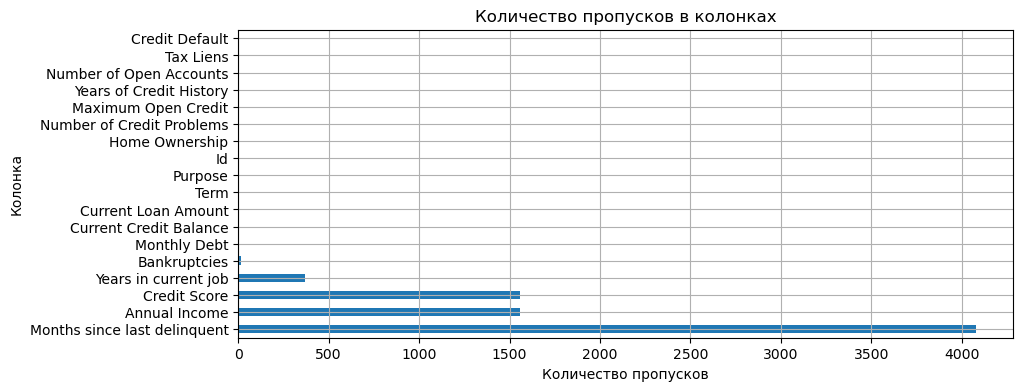

In [21]:
# общая информация
data_info(train)

### Вывод по train
- В датасете `train` 7500 строк и 18 колонок, из которых `Credit Default` - целевой признак
- Есть пропуски в столбцах `Annual Income`, `Years in current job`, `Months since last delinquent`, `Bankruptcies`, `Credit Score`
- Удобнее будет`Id` перенести в индекс
- Тип данных корректный
- В столбцах `Maximum Open Credit`, `Current Loan Amount` и `Credit Score` видно значительные отличия среднего значения от медианы, возможно аномальные значения

Hазмер датасета (2500, 17)
__________________________________________________


,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,7500,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,7501,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,7502,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,7503,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,7504,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            2500 non-null   int64  
 1   Home Ownership                2500 non-null   object 
 2   Annual Income                 1987 non-null   float64
 3   Years in current job          2414 non-null   object 
 4   Tax Liens                     2500 non-null   float64
 5   Number of Open Accounts       2500 non-null   float64
 6   Years of Credit History       2500 non-null   float64
 7   Maximum Open Credit           2500 non-null   float64
 8   Number of Credit Problems     2500 non-null   float64
 9   Months since last delinquent  1142 non-null   float64
 10  Bankruptcies                  2497 non-null   float64
 11  Purpose                       2500 non-null   object 
 12  Term       

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2500.00000,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,8749.50000,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,721.83216,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,7500.00000,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8124.75000,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,8749.50000,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,9374.25000,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,9999.00000,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


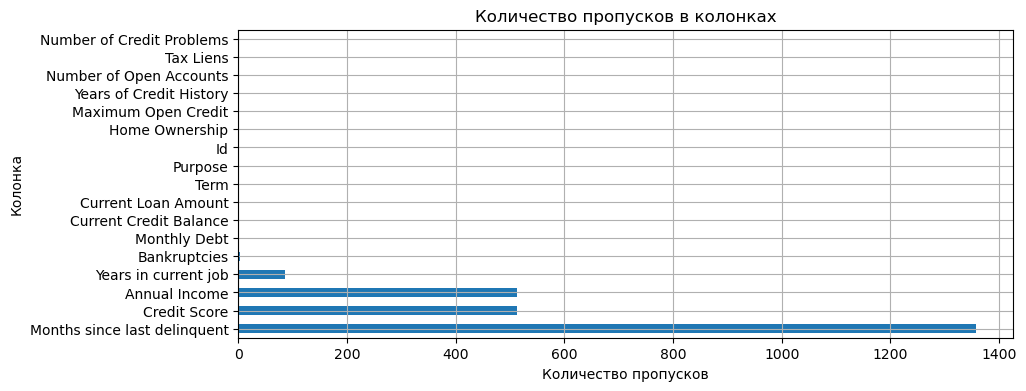

In [23]:
# общая информация 
data_info(test)

Попробуем разобраться с фичами для более полного понимания данных:
- Home Ownership: Тип жилья, которым владеет заемщик. 
- Annual Income: Ежегодный доход заемщика.
- Years in current job: Количество лет работы на текущем месте работы. 
- Tax Liens: Количество налоговых обременений на имущество заемщика.
- Number of Open Accounts: Количество открытых кредитных счетов.
- Years of Credit History: Количество лет кредитной истории.
- Maximum Open Credit: Максимальный кредитный лимит на всех открытых счетах.
- Number of Credit Problems: Количество проблем с кредитом в прошлом.
- Months since last delinquent: Количество месяцев с момента последней просрочки по платежу.
- Bankruptcies: Количество банкротств.
- Purpose: Цель получения кредита. 
- Term: Срок кредита. 
- Current Loan Amount: Текущая сумма кредита. 
- Current Credit Balance: Текущий остаток долга по кредиту.
- Monthly Debt: Ежемесячный платеж по долгу. 
- Credit Score: Кредитный рейтинг заемщика. 

####  Вывод по test
- В целом ситуация аналогичная с `train`
- В датасете `test` 2500 строк и 17 колонок
- Есть пропуски в столбцах `Annual Income`, `Years in current job`, `Months since last delinquent`, `Bankruptcies`, `Credit Score`
- `Id` - перенести в индекс, начинается с 7500 позиции
- тип данных корректный
- В столбцах `Maximum Open Credit`, `Current Loan Amount` и `Credit Score` видно значительные отличия среднего значения от медианы, возможно аномальные значения

## Предобработка данных

In [27]:
# перевод Id в индекс 
train = train.set_index('Id')
test = test.set_index('Id')

In [28]:
# Поиск дубликатов
train = duplicat(train)

Размер DataFrame с дубликатами: (7500, 17)
Количество строк дубликатов: 0
Размер DataFrame без дубликатов: (7500, 17)


In [29]:
# Поиск дубликатов
test = duplicat(test)

Размер DataFrame с дубликатами: (2500, 16)
Количество строк дубликатов: 0
Размер DataFrame без дубликатов: (2500, 16)


- Поиск дубликатов требуется проводить после перевода `Id` в индекс и без целевого признака `Credit Default`, так как при обучении модели, если не учесть это, то могут образовываться дубликаты, которые не будут полезны для модели.
- Дубликатов не обнаружено

In [31]:
#смотрим уникальные значения 
hidden_duplicat(train)

Уникальные значения для столбца 'Home Ownership': ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
Уникальные значения для столбца 'Years in current job': [nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']
Уникальные значения для столбца 'Purpose': ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']
Уникальные значения для столбца 'Term': ['Short Term' 'Long Term']


In [32]:
#смотрим уникальные значения 
hidden_duplicat(test)

Уникальные значения для столбца 'Home Ownership': ['Rent' 'Home Mortgage' 'Own Home' 'Have Mortgage']
Уникальные значения для столбца 'Years in current job': ['4 years' '1 year' '3 years' '10+ years' '6 years' '5 years' '< 1 year'
 '2 years' '9 years' '8 years' '7 years' nan]
Уникальные значения для столбца 'Purpose': ['debt consolidation' 'educational expenses' 'home improvements'
 'major purchase' 'other' 'buy a car' 'medical bills' 'buy house'
 'business loan' 'take a trip' 'small business' 'moving' 'vacation'
 'wedding']
Уникальные значения для столбца 'Term': ['Short Term' 'Long Term']


Пропуски не следует обрабатывать отдельно каждый, так как при выгрузке данных могут образоваться еще пропуски, которsе не будут учтены при создании моделей МО. Поэтому пропуски лучше обрабатывать в пайплане при помощи `SimpleImputer`

####  Вывод
- Переведен `Id` в индекс, чтобы не мешал вычислениям
- Дубликатов не обнаружено. Проверка проводилась после перевода `Id` в индекс и без учета таргета
- Скрытых дубликатов, опечаток и т.д. - не обнаружено
- Пропуски будут обрабатываться централизованно в рамках общего пайплана машинного обучения

## Исследовательский анализ данных

- Из `num_cols` мы удалили бинарный целевой признак `Credit Default` признак, чтобы лучше его визуализировать.

Так как для корректной визуализации необходимо разделить числовые признаки на дискретные и непрерывные, то получаем следуюище списки: 
- Дискретные признаки: `Tax Liens`, `Number of Open Accounts`, `Number of Credit Problems`, `Months since last delinquent`, `Bankruptcies`
- Непрерывные признаки: `Annual Income`, `Years of Credit History`, `Maximum Open Credit`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Score`

In [37]:
# разделение на числовые признаки 
num_cols = train.select_dtypes(include='number').drop(['Credit Default'], axis=1).columns.tolist()
# непрерывные признаки
num_cont = ['Annual Income', 'Years of Credit History', 'Maximum Open Credit',
           'Current Loan Amount','Current Credit Balance', 'Monthly Debt', 'Credit Score']
# дискретные признаки
num_des = ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies']
# целевой признак
target = ['Credit Default']
# разделение на категориальные признаки 
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

### Непрерывные признаки

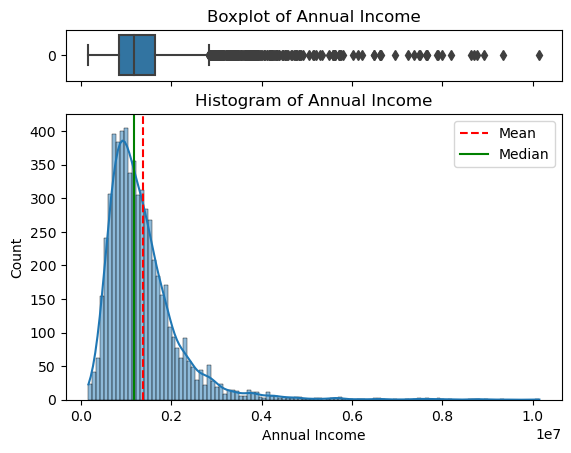

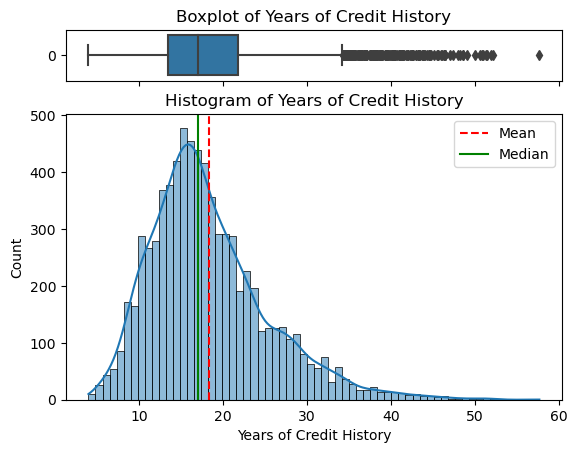

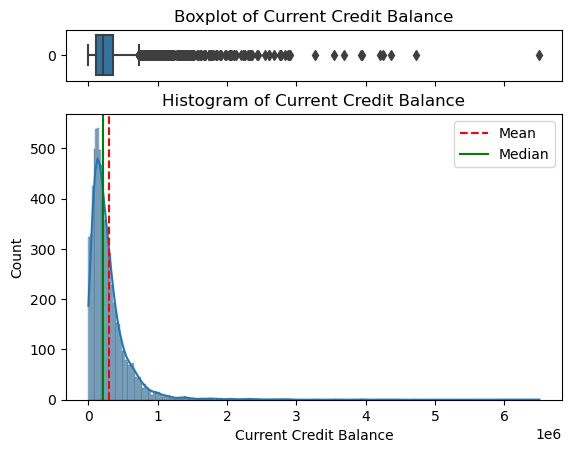

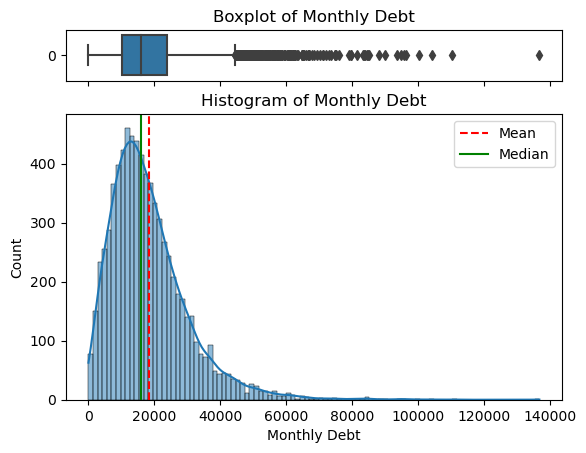

In [39]:
# построение графиков для непрерывных величин
make_hist_box(train, ['Annual Income', 'Years of Credit History','Current Credit Balance', 'Monthly Debt'])

Ранее было предположение, что в  столбцах `Maximum Open Credit`, `Current Loan Amount` и `Credit Score` возможны аномальные значения, так как видно значительные отличия среднего значения от медианы. То построим боксплот, если будут выбросы, мы сделаем срез по правилу 3-сигм, чтобы смогли описать распределение данных без влияния аномальных значений

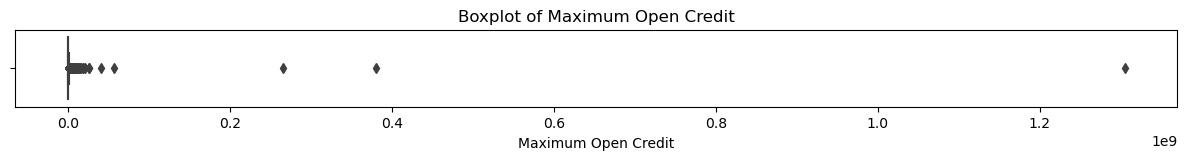

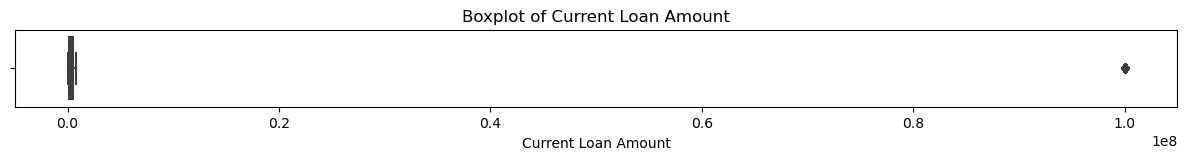

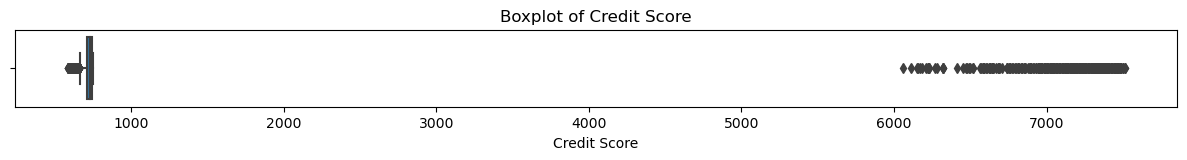

In [41]:
# построение боксплотов для признаков с аномалиями
make_boxplot(train, ['Maximum Open Credit', 'Current Loan Amount', 'Credit Score'])

In [42]:
# Удаляем аномалии из столбца  
train_for_graph_1 = anomalies_3_sigma(train, 'Maximum Open Credit')
train_for_graph = anomalies_3_sigma(train_for_graph_1, 'Credit Score')

# Выводим исходный и очищенный DataFrame
print("Исходный DataFrame:")
print(train.shape)
print("\nDataFrame без аномалий:")
print(train_for_graph.shape)

Исходный DataFrame:
(7500, 17)

DataFrame без аномалий:
(5540, 17)


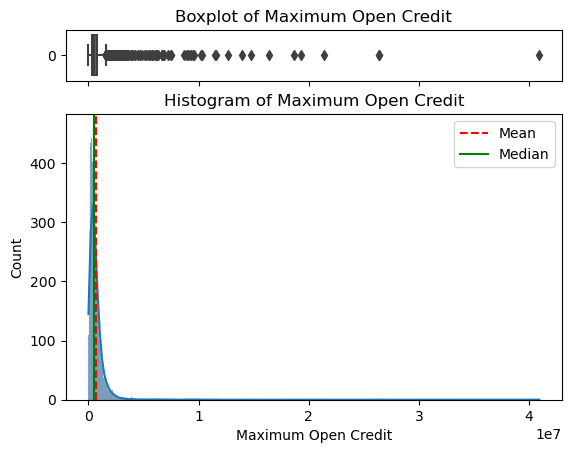

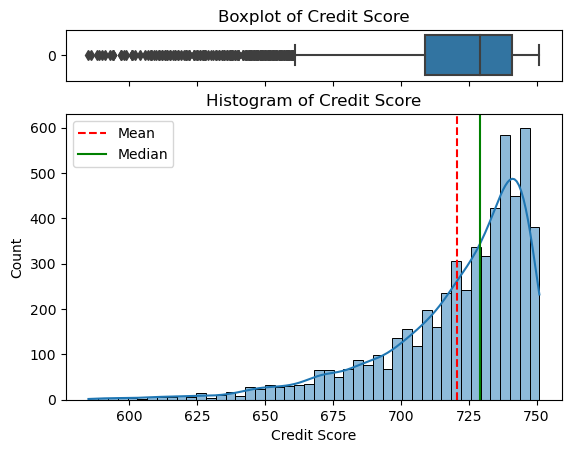

In [43]:
# построение графиков для непрерывных величин
make_hist_box(train_for_graph, ['Maximum Open Credit', 'Credit Score'])

Значение в `Current Loan Amount`, которые выбивается похоже на заглушку, которую вставляют вместо пропусков, чтобы значение бросалось в глаза. Значение "заглушки" 99999999.0

In [45]:
# срез без аномального значения 
upper_bound = max(train_for_graph['Current Loan Amount'])
train_for_graph = train_for_graph[(train_for_graph['Current Loan Amount'] < upper_bound)]

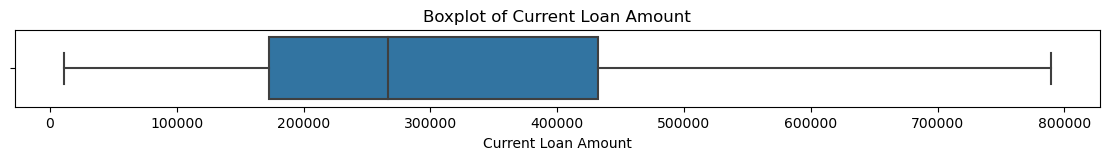

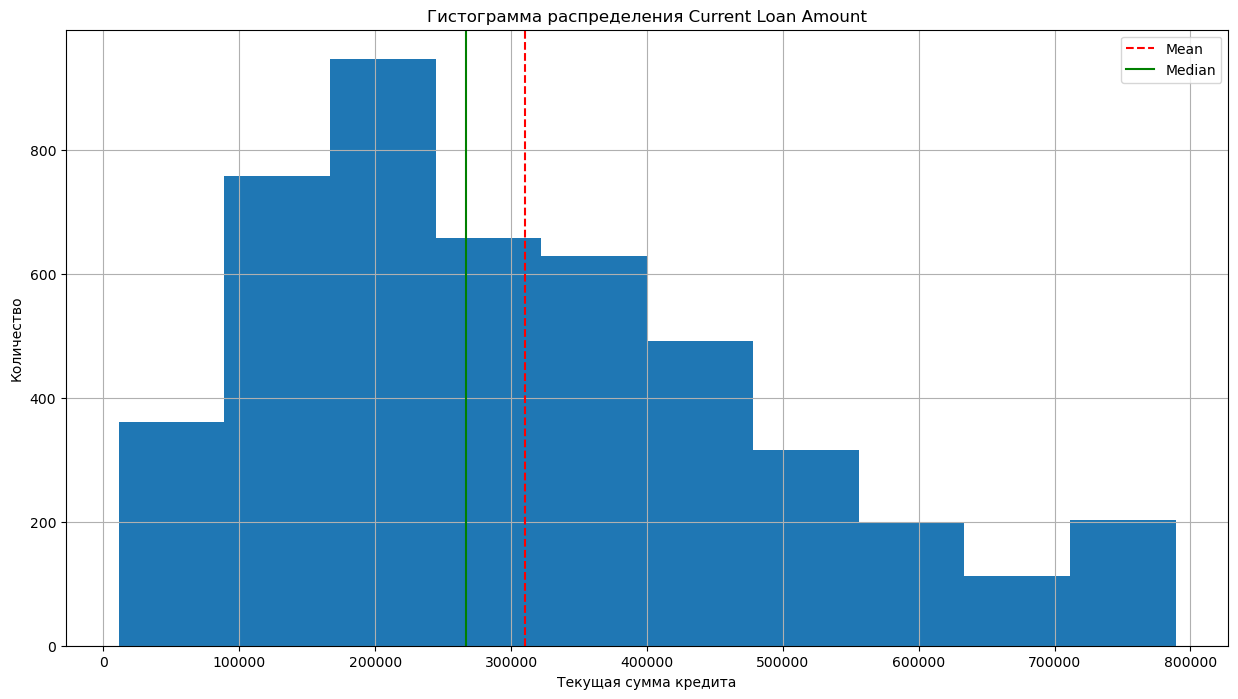

In [46]:
# построение распределения 
current_loan_amounts = train_for_graph['Current Loan Amount']

# Построение боксплота
plt.figure(figsize=(14, 1))
sns.boxplot(x=current_loan_amounts, data=train_for_graph)
plt.title(f'Boxplot of Current Loan Amount')
plt.show()

# Построение гистограммы
plt.figure(figsize=(15, 8))
current_loan_amounts.hist(bins=10)
plt.axvline(current_loan_amounts.mean(), color='r', linestyle='--', label='Mean')
plt.axvline(current_loan_amounts.median(), color='g', linestyle='-', label='Median')
plt.xlabel('Текущая сумма кредита')
plt.ylabel('Количество')
plt.title('Гистограмма распределения Current Loan Amount')
plt.grid(True)
plt.legend()
plt.show()

**Выводы**
- Были обнаружены аномальные значения, однако удалить их не можем, так как требуется уточнение специалиста о природе образования таких аномальных значениях, возможно, это входит в норму. Для модели лучше сохранить как можно больше данных для обучения

### Дискретные признаки

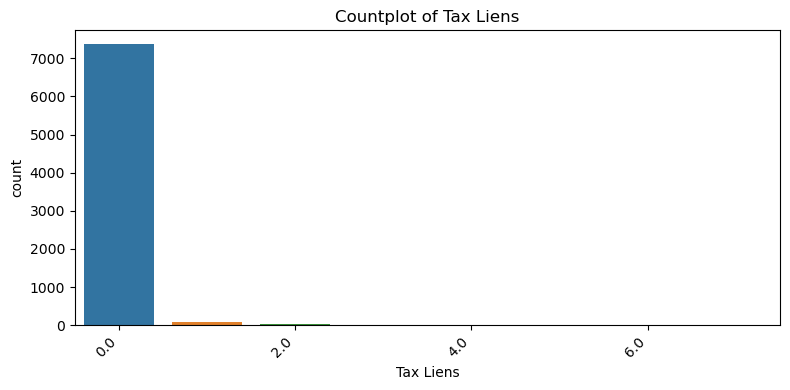

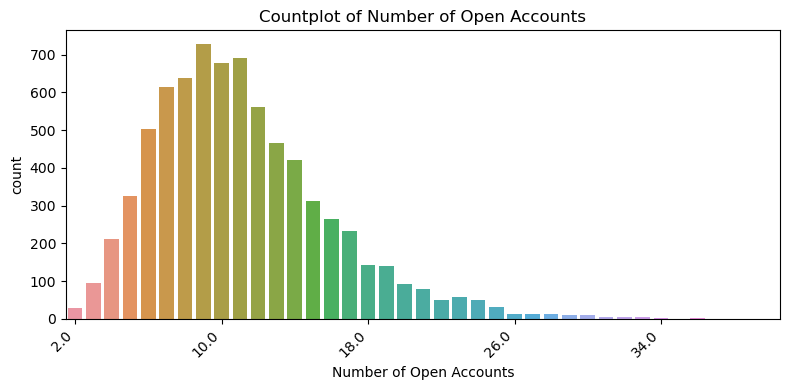

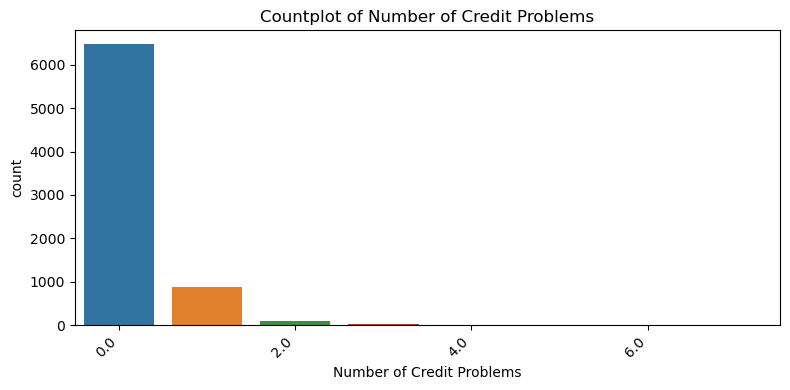

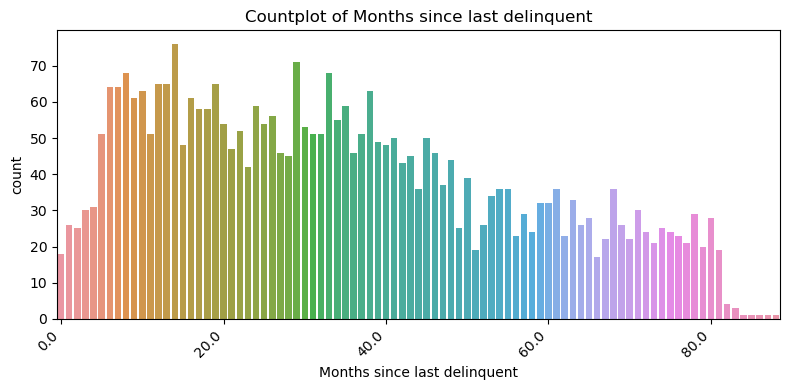

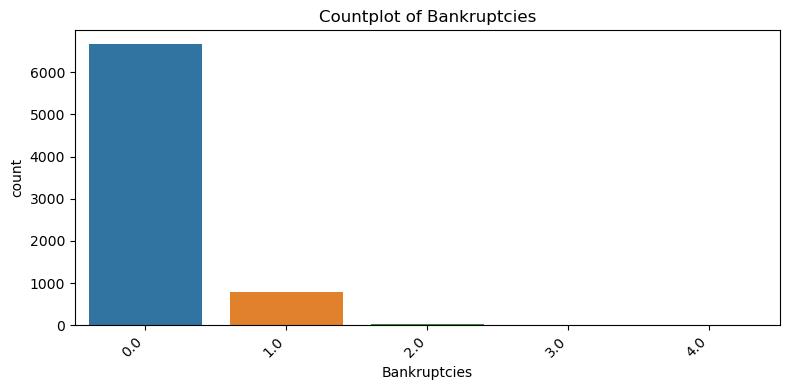

In [49]:
# построение графиков для дискретнх величин
make_countplot(train, ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies'])

### Целевой признак

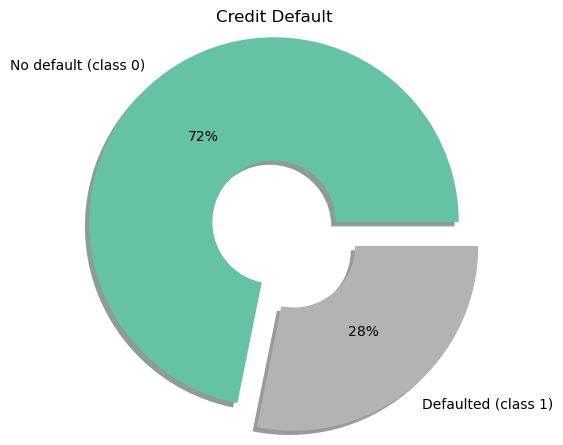

In [51]:
# График для целевого признака
target_values = train['Credit Default'].value_counts()

plt.figure(figsize=(7, 5), facecolor='w')
pie, *_ = plt.pie(target_values, autopct='%.f%%', labels=['No default (class 0)', 'Defaulted (class 1)'], 
                  explode=[0, 0.2], shadow=True, radius=1.2, colors=plt.cm.Set2(np.linspace(0, 1, 2)), 
                  wedgeprops={'lw': 0})
plt.setp(pie, width=0.8)
plt.title('Credit Default')
plt.show()

### Категориальные признаки

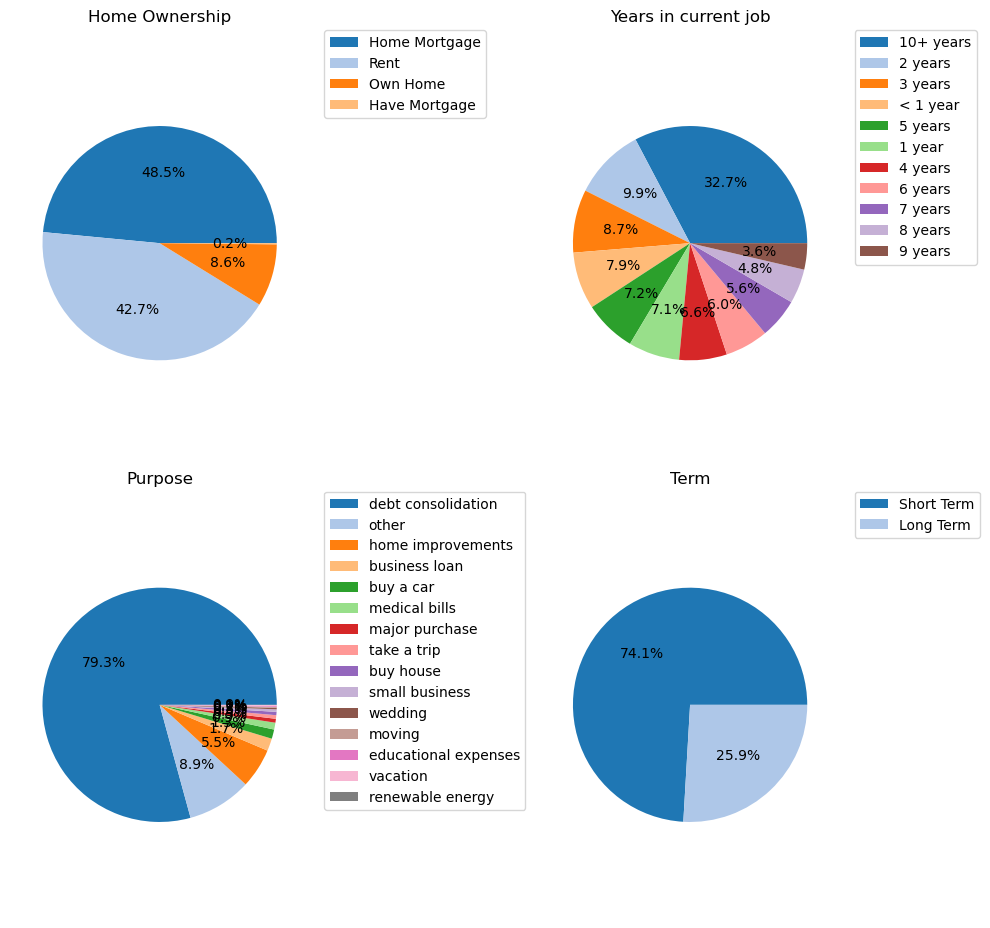

In [53]:
# построение графиков для категориальных признаков
ncols = 2
nrows = (len(cat_cols) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
axes = axes.ravel()

for i, feature in enumerate(cat_cols):
    ax = axes[i]
    feature_counts = train[feature].value_counts()
    # Используем цветовую карту tab20
    ax.pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%', colors=plt.cm.tab20(range(len(feature_counts))),
            # Убираем легенду с диаграммы 
            labeldistance=None) 
    ax.set_title(feature)
    ax.axis("equal")
    # Размещаем легенду вне графика
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 

plt.subplots_adjust(wspace=0.6, hspace=1)
plt.tight_layout()
plt.show()

**Вывод** 
- Annual Income - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 0.3
- Years of Credit History - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 5 до 35
- Current Credit Balance - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 1
- Monthly Debt - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 40000
- У 'Maximum Open Credit', 'Current Loan Amount', 'Credit Score' имеются аномальные значения, которые выбиваются из общего количества, поэтому для изучения распределения удалим их, но оставим для обучения. Удаление проводим по правилу 3-сигм.
- Maximum Open Credit - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 0,2
- Credit Score - распределение скошено влево, виден длинный хвост в низкой области, основное значение лежит от 675 до 750
- Current Loan Amount - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 100 до 450 тыс
- Tax Liens - основное значение имеет "0", остальные значения почти незначительны
- Number of Open Accounts - пик распределения наблюдается при 10, распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 5 до 18
- Number of Credit Problems - наиболешее значение имеет "0", затем почти в 7 раз меньше "1" и еще в 5 раз меньше "2"
- Months since last delinquent - видно несколько пиков, от 10 до 20, от 30 до 40, от 50 до 65. Примечательно что больше 82 почти не происходит просрочка
- Bankruptcies - наиболешее значение имеет "0", затем почти в 7 раз меньше "1"
- **Credit Default** - виден дисбаланс класса, преимущество почти в 2,3 раза больше кол-во клиентов без дефолта (класс 0)
- Home Ownership - 4 варианта, из которых 2 варианта, а именно Home Mortgage и Rent имеют 48,5 и 42,7% соответственно от общего количества
- Years in current job - чаще всего люди работают более 10 лет, затем 2, после чего 3 и затем меньше 1 года 
- Purpose - Большая часть количества клиентво (79%) берет кредит на debt consolodation, после чег оother (8.9%)
- Term - распределение на 2 значения, short term гораздо больше (74,1%), чем long term (25,9%)

## Портрет заемщика с дефолтом

In [56]:
# построение графиков разделенных по целевому классу
def plot_credit_default_distributions(data):
    fig = plt.figure(figsize=(16, 20))
    
    # Создание субплотов в цикле
    for i, feature in enumerate(num_cols):
        ax = fig.add_subplot(4, 3, i+1)
        
        if feature == 'Credit Score':
            sns.histplot(data=data, x=feature, log_scale=True, kde=True, palette='Set2', hue='Credit Default', ax=ax)
        else:
            sns.histplot(data=data[data[feature] > 0], x=feature, log_scale=True, kde=True, palette='Set2', hue='Credit Default', ax=ax)
        
        ax.set_title(f'Распределение {feature}', fontsize=12, pad=15)
    
    plt.tight_layout()
    plt.show()

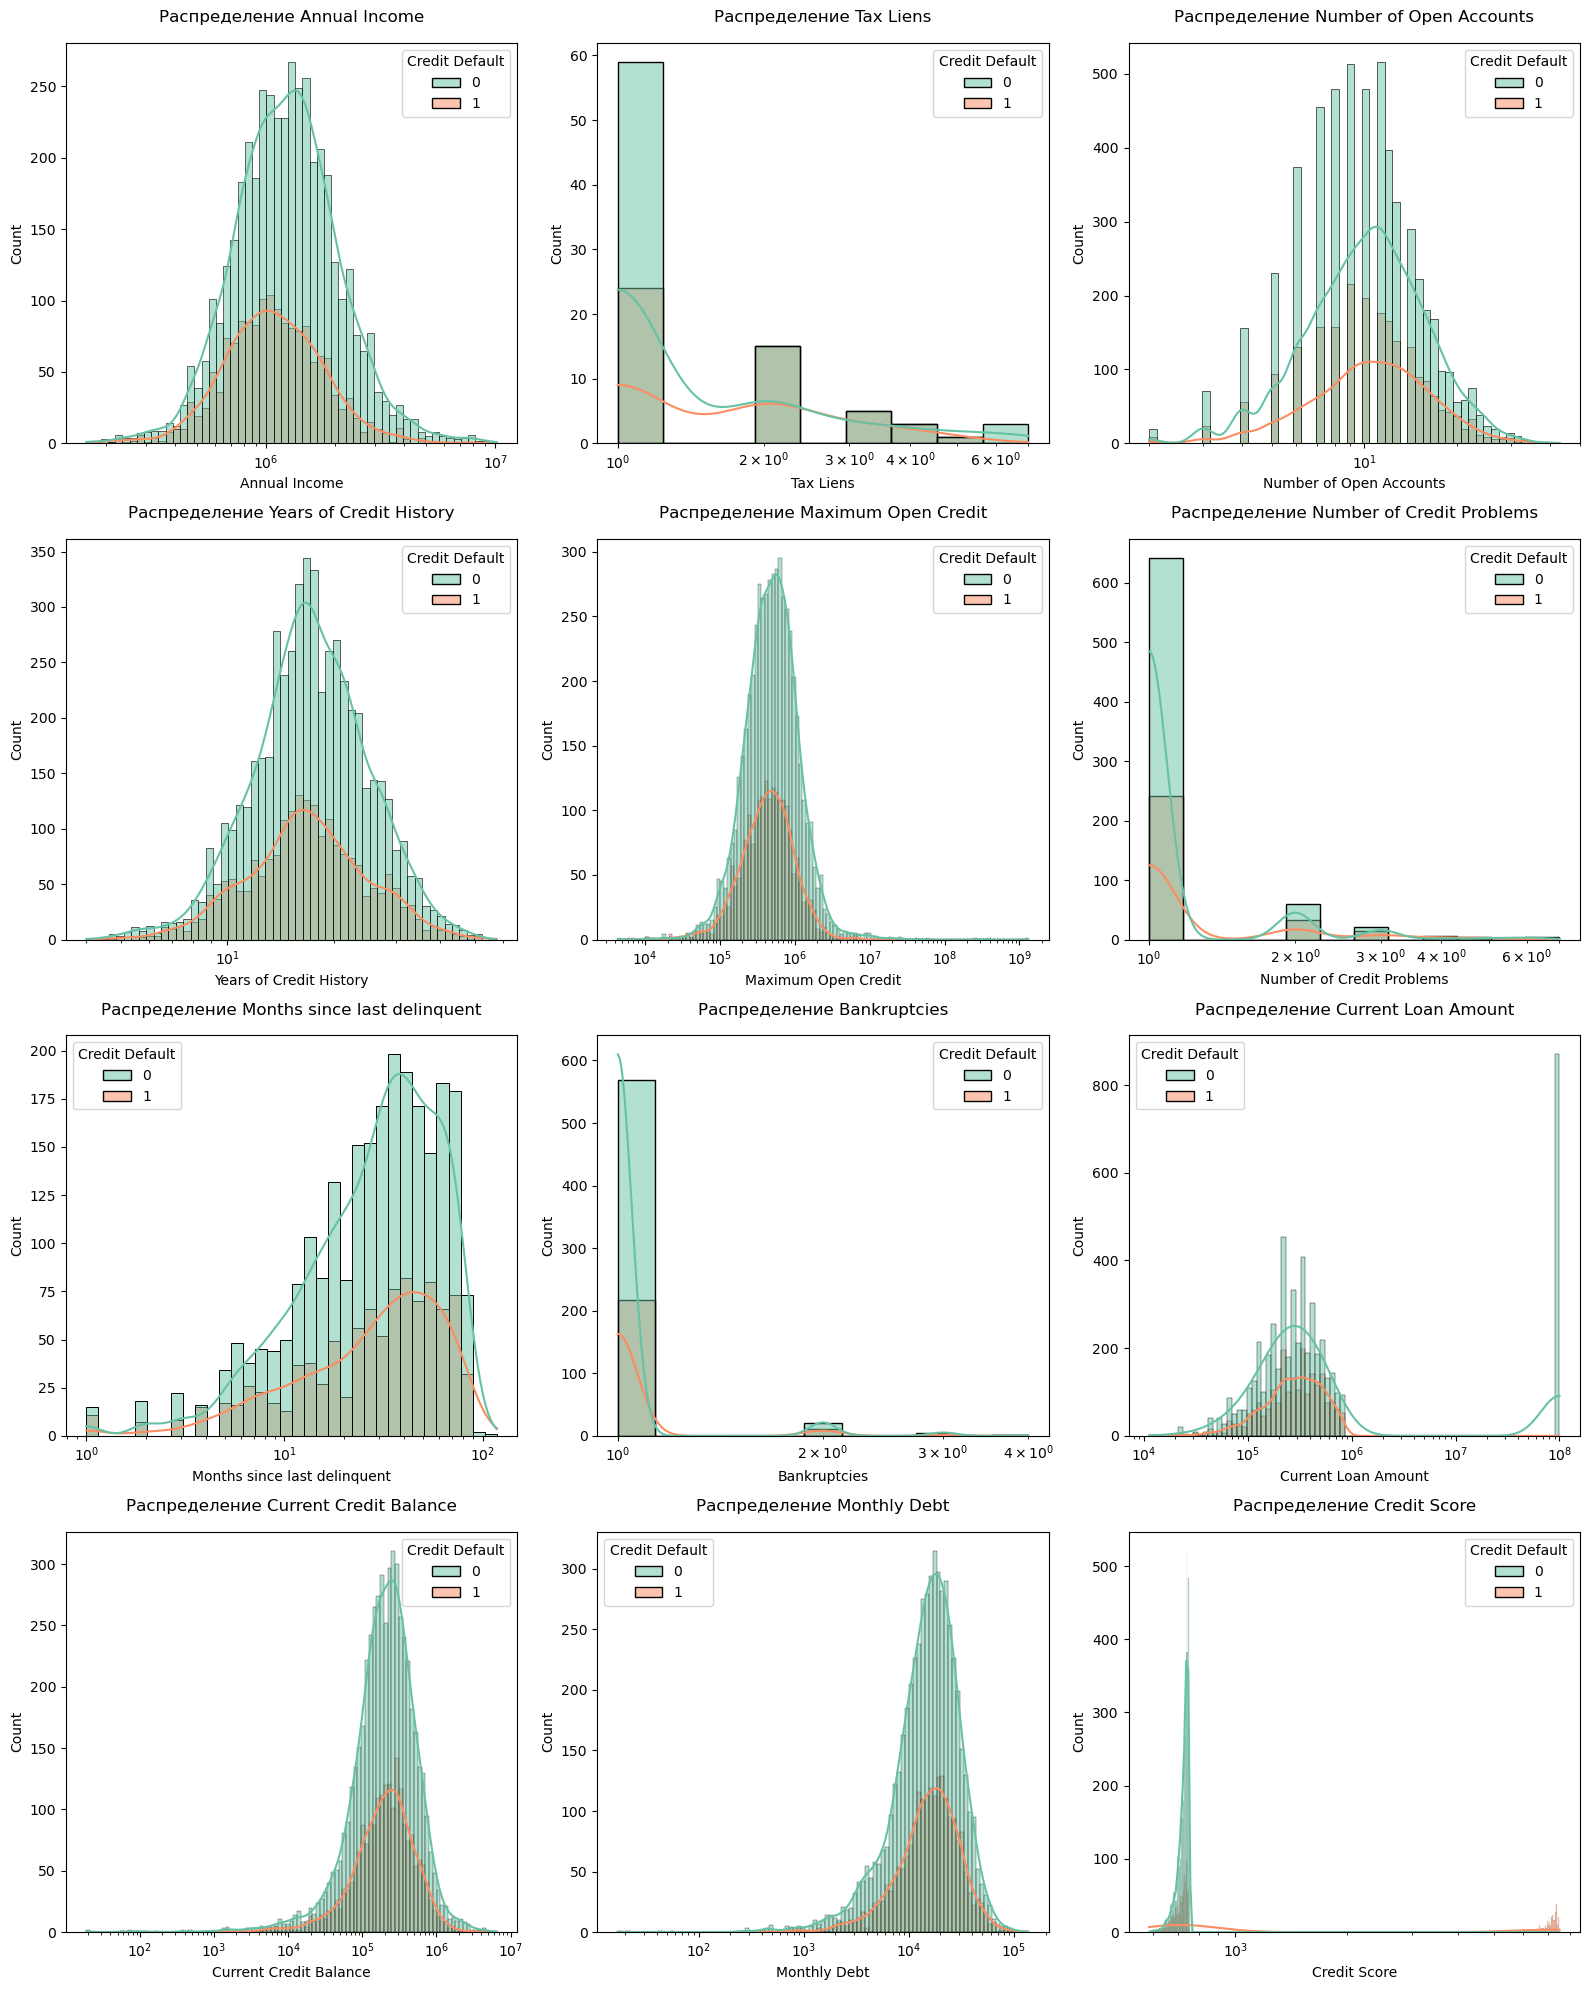

In [57]:
 plot_credit_default_distributions(train)

,Уникальные значения столбца Home Ownership,Доля клиентов,Credit Default
0,Own Home,0.70,0
1,Home Mortgage,0.75,0
2,Rent,0.69,0
3,Have Mortgage,0.83,0
4,Own Home,0.30,1
5,Home Mortgage,0.25,1
6,Rent,0.31,1
7,Have Mortgage,0.17,1


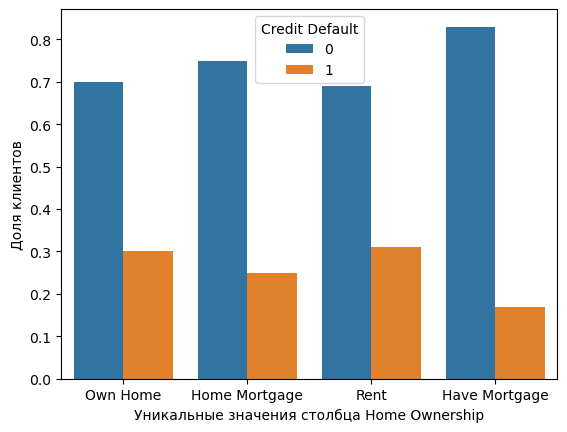


__________________________________________________



,Уникальные значения столбца Years in current job,Доля клиентов,Credit Default
0,nan,NaN,0
1,10+ years,0.72,0
2,8 years,0.73,0
3,6 years,0.71,0
4,7 years,0.72,0
5,5 years,0.72,0
6,1 year,0.72,0
7,< 1 year,0.72,0
8,4 years,0.72,0
9,3 years,0.73,0


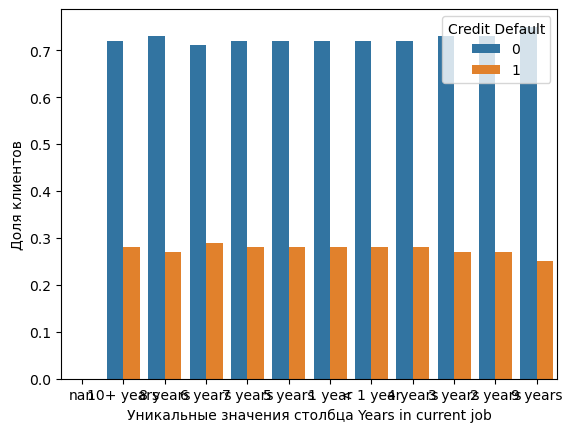


__________________________________________________



,Уникальные значения столбца Purpose,Доля клиентов,Credit Default
0,debt consolidation,0.72,0
1,other,0.70,0
2,home improvements,0.74,0
3,take a trip,0.73,0
4,buy a car,0.75,0
5,small business,0.46,0
6,business loan,0.57,0
7,wedding,0.73,0
8,educational expenses,0.90,0
9,buy house,0.74,0


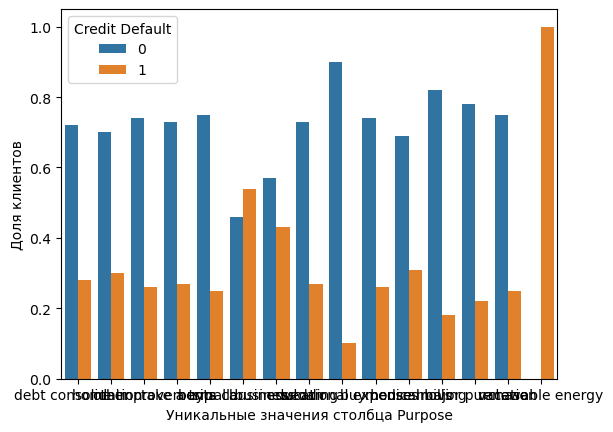


__________________________________________________



,Уникальные значения столбца Term,Доля клиентов,Credit Default
0,Short Term,0.77,0
1,Long Term,0.58,0
2,Short Term,0.23,1
3,Long Term,0.42,1


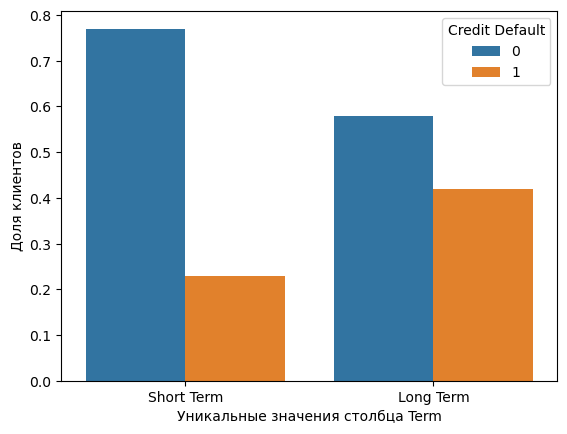


__________________________________________________



In [58]:
# изучим партрет клиентов с дефолтом 
for i in cat_cols:
    proba_plot(train, i)

**Вывод**
* `Home Ownership` - меньше всего вероятность встретить заемщика с дефолтом, имеющий тип `Have Mortgage`
* `Years in current job` - клиентов с дефолтом от меньше 1 года до более 10 лет имеют примерое одинаковую долю
* `Purpose`: Высокая вероятность встретить клиентов с дефолтом при цели кредитования - `renewable energy`, `small business` и `business loan`. Причем доля `renewable energy` = 1.0. Меньше всего шанс встретить клиентов с дефолтом с целью `educational expenses`
* `Term` - Почти в 2 раза больше доля клиентов с дефолтом встречается при `Long Trm`


## Корреляционный анализ

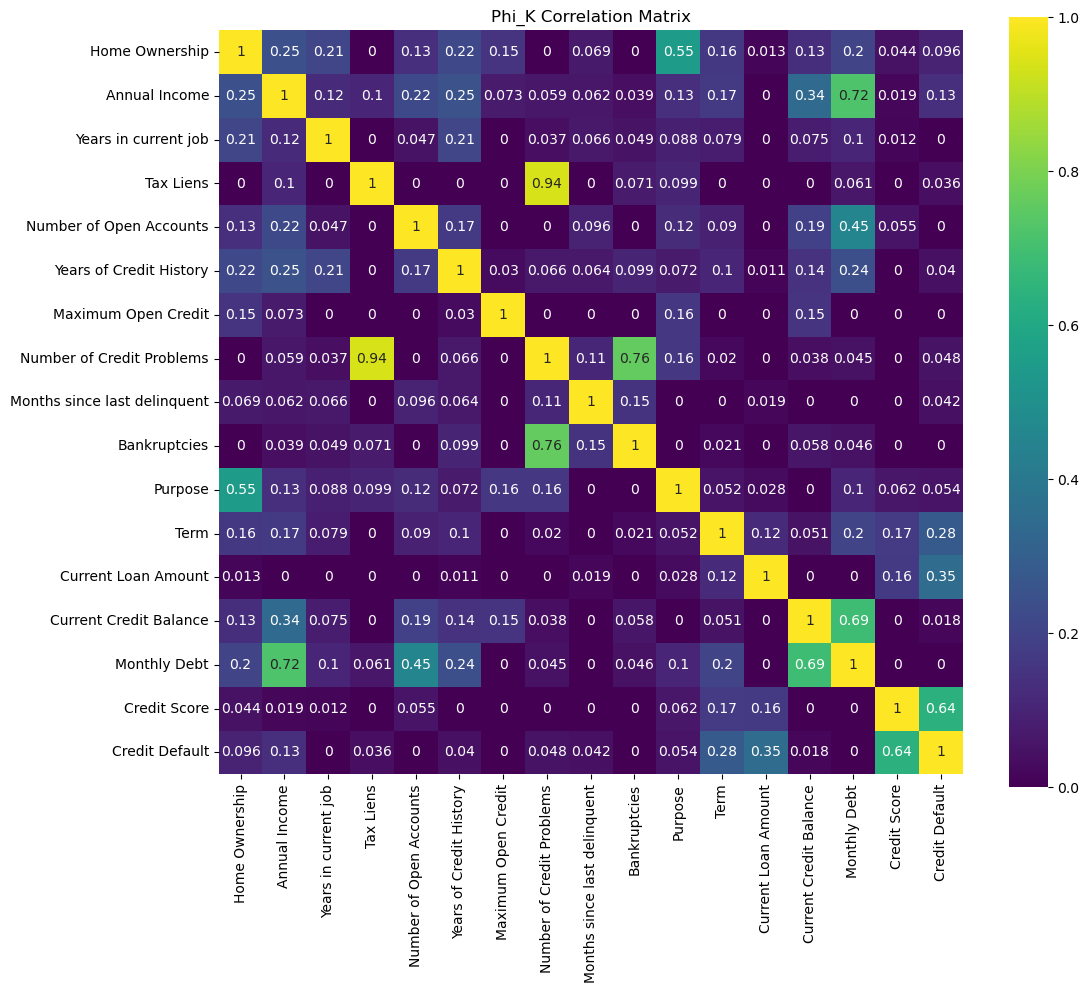

In [61]:
# Создание фигуры и осей с заданным размером
plt.figure(figsize=(12, 10))

# Построение тепловой карты
heatmap = sns.heatmap(train.phik_matrix(interval_cols=num_cols), annot=True, cmap='viridis', square=True)

# Добавление названия к тепловой карте
heatmap.set_title('Phi_K Correlation Matrix')

# Отображение тепловой карты
plt.show();

Основные рекомендации библиотеки Phik:

• Диапазон Phik: Значения Phik находятся в диапазоне от 0 до 1, где:
- 0 означает отсутствие ассоциации.
- 1 означает идеальную ассоциацию.

• Интерпретация значений:
-  Слабая ассоциация: Phik от 0 до 0.3
- Умеренная ассоциация: Phik от 0.3 до 0.7
- Сильная ассоциация: Phik от 0.7 до 1
  
В данном проекте исключим мультиколлинеарные признаки, с корреляцией выше 0.85

In [63]:
# Получение phi_k корреляционной матрицы
phi_k_matrix = train.phik_matrix(interval_cols=num_cols)

# Поиск столбцов с корреляцией выше 0.85
high_corr_cols = set()
for col1 in phi_k_matrix.columns:
    for col2 in phi_k_matrix.columns:
        if phi_k_matrix.loc[col1, col2] > 0.85 and col1 != col2:
            high_corr_cols.add(col1)
            high_corr_cols.add(col2)

# Вывод названий столбцов с высокой корреляцией
print("Столбцы с корреляцией выше 0.85:")
for col in high_corr_cols:
    print(f"- '{col}'")

Столбцы с корреляцией выше 0.85:
- 'Tax Liens'
- 'Number of Credit Problems'


## Подготовка данных

Исходную тестовую выборку оставим для того, чтобы совершить предсказание на лучшей модели. Для построения визуализации то, как предсказанное значение соответсвуте реальному значению класса и для построения матрицы ошибок - необходимо будет `train` разделить на трейн и валидационную выборку. Для подбора гиперпараметров по лучшей метрике мы будем ориентироваться на значение метрики по кросс-валидации. Но для финальной оценки модели используем валидационную выборку. Такой способ имеет недостатки за счет того, что количество данных для обучения на трейне сократится 

In [66]:
# Удаление признаков в высокой мультиколлинеарностью 
train = train.drop(['Number of Credit Problems', 'Tax Liens'], axis=1)
X_test = test.drop(['Number of Credit Problems', 'Tax Liens'], axis=1)

In [67]:
# Назначение переменных фичей и целевого признака
X = train.drop(columns=['Credit Default'])
y = train['Credit Default']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size=0.1, shuffle=True) #stratify=y)

print('Размер тренировочной выборки - {:.0%}'.format(X_valid.shape[0]/(X_valid.shape[0]+X_train.shape[0])))

Размер тренировочной выборки - 10%


In [68]:
# создание списков с количественными и категориальными признаками
num_columns = X_train.select_dtypes(include=['float', 'int']).columns.tolist()
ohe_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [69]:
print("Количество столбцов в X_train:", len(X_train.columns))
print("Количество категориальных столбцов для кодера:", len(ohe_columns))
print("Количество числовых столбцов для масштабирования:", len(num_columns ))

Количество столбцов в X_train: 14
Количество категориальных столбцов для кодера: 4
Количество числовых столбцов для масштабирования: 10


In [70]:
X = train.drop(columns=['Credit Default'])
y = train['Credit Default']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True) #stratify=y)

## Обучение модели

Самые популярные способы решения проблемы с дисбалансом класса: 
- 1. Сэмплирование
    - Использовать Oversampling. Увеличение минорного класса. Например, SMOTE, ADASYN и другие
    - Использование Undersampling. Удаление из выборки объектов мажорного класса. Например, RandomUnderSampler, Tomek Links и другие
- 2. Взвешивание классов моделью. Настройка модели так, чтобы она внимательнее изучала объекты минорного класса.
- 3. Использование метрики, чувствительной к дисбалансу.
    - F1-score учитывает как точность, так и полноту прогнозирования. F1-мера снижается, когда модель из-за дисбаланса плохо предсказывает минорный класс. Поэтому смотрим на неё в первую очередь.
- 4. Использование методов, устойчивых к дисбалансу    - Алгоритмы типа Random Forest, XGBoost, LightGBM, которые менее чувствительны к дисбалансов

В проекте я использую метрику F1 и модели Random Forest, XGBoost, LightGBM, чтобы модель не завышала показатели мы не будем увеличивать количество минорного класса.

In [73]:
%%time

# Создаем пайплайн для подготовки данных и модели
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('num', RobustScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('nan_imputer',  SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    #('feature_selection', SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE))),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Определяем параметры для поиска
param_grid = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [5, 10, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [3, 5, 7, 9],
        'models__learning_rate': [0.01, 0.1, 0.3],
        'models__subsample': [0.7, 0.8, 1.0],
        'models__colsample_bytree': [0.7, 0.8, 1.0],
        'models__gamma': [0, 0.1, 0.2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
        
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__learning_rate': [0.01, 0.1, 0.3],
        'models__num_leaves': [31, 50, 100],
        'models__max_depth': [-1, 5, 10],
        'models__subsample': [0.7, 0.8, 1.0],
        'models__colsample_bytree': [0.7, 0.8, 1.0],
        'models__reg_alpha': [0, 0.1, 0.5],
        'models__reg_lambda': [0, 0.1, 0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
      #Ensemble Methods   
    {    
        'models': [
            RandomForestClassifier(random_state=RANDOM_STATE),
            XGBClassifier(random_state=RANDOM_STATE),
            LGBMClassifier(random_state=RANDOM_STATE)
        ],
        'models__n_estimators': [50, 100, 200],
        'models__criterion': ['gini', 'entropy'],
        'models__max_depth': [None, 5, 10, 20],
        'models__min_samples_split': [2, 5, 10]
    }
]

# Выполняем поиск гиперпараметров с использованием F1-score
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='f1',
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1,
    cv=5,
    n_iter=100
)

randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_

print('Лучшая модель и её параметры:\n\n', best_model)
print('Метрика F1 лучшей модели на кросс-валидации:', round(best_score, 3))

[LightGBM] [Info] Number of positive: 1654, number of negative: 4346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.275667 -> initscore=-0.966059
[LightGBM] [Info] Start training from score -0.966059
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  

## Анализ важности признаков

In [75]:
# извлечения имен признаков после преобразования данных с помощью ColumnTransformer
ohe_columns_2 = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
num_columns_2 = best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

In [76]:
# преобразовать и подготовить как тренировочные данные
X_train_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)

In [77]:
# объединение 
columns_conc = np.concatenate((ohe_columns_2,num_columns_2), axis =0)

In [78]:
# переводим массив в датафрейм
X_train_transformed= pd.DataFrame(X_train_transformed, columns = columns_conc )

In [ ]:
#получение параметров модели из пайплана 
LightGBM = best_model.named_steps['models']

#создание объяснителя (explainer) для модели машинного обучения, используя преобразованные данные тренировочной выборки X_train_transformed.
explainer = shap.Explainer(LightGBM, X_train_transformed)

#получение значений значимости вклада каждого признака для каждого экземпляра тестовой выборки
shap_values = explainer (X_train_transformed)

 44%|=========           | 2661/6000 [00:14<00:17]       

In [ ]:
#создание сводной диаграммы SHAP значений
shap.summary_plot(shap_values.values, X_train_transformed, plot_type ="bar", plot_size =(15,10), show=False)
plt.title('Shap Summary Plot', fontsize = 10)
plt.show;

**Выводы**
Признаки по важности для модели LGBMClassifier:
- `Current Loan Amount`>`Credit Score`>`Annual Income`>`Maximum Open Credit`>`Months since last delinquent`>`Term_Short Term`>`Number of Open Accounts`> `Monthly Debt`>`Years of Credit History`>`Current Loan Amount`>`Home Ownership_Rent`>`Home Ownership_Home Mortgage`>`Years in current job_10+years`>`Purpose_debt consolidation`>`Purpose_medicak bills`>`Years in current job_5 years`>`Years in current job_3 years`>`Years in current job_<1 year`>`Years in current job_2 years`>`Years in current job_8 years`

## Финальная оценка

In [ ]:
# Проверка работы модели на валидационной выборке
y_pred_val = best_model.predict(X_valid)
f1 = f1_score(y_valid, y_pred_val)
print(f"F1-метрика: {round(f1,3)}")

In [ ]:
# Визуализация матрицы ошибок
cm = confusion_matrix(y_valid, y_pred_val)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Класс 0', 'Класс 1'])
cmd.plot(cmap='Blues')

# Добавляем названия элементов матрицы
plt.text(0, 0.8, 'False Negative (FN)', fontsize=12, ha="center", va="center")
plt.text(1, 0.8, 'True Positive (TP)', fontsize=12, ha="center", va="center")
plt.text(0, -0.2, 'True Negative (TN)', fontsize=12, ha="center", va="center", color="white")
plt.text(1, -0.2, 'False Positive (FP)', fontsize=12, ha="center", va="center")
plt.show()

**Выводы**
Основываясь на матрице ошибок, видно:

- True Positive (TP):  165 - верно классифицированы моделью как пользователи с дефолтом и на самом деле был дефолт
- True Negative (TN):  972- верно классифицированы моделью как пользователи без дефолта и на самом деле не было дефолта
- False Positive (FP): 69 - пользователи ошибочно классифицированы моделью как с дефолтом, но на самом деле не было дефолта
- False Negative (FN): 294- пользователи ошибочно классифицированы моделью как без дефолта, но на саммо деле был дефолт

Ошибки второго рода (FN) являются более критичными для банка, поскольку они приводят к неспособности вовремя выявить "проблемных" заемщиков и предпринять соответствующие меры, что может привести к более значимым финансовым потерям (потеря денег, невыплата процентов).

## Анализ модели на адекватность 

In [ ]:
# обучения модели DummyClassifier 
model_dmr = DummyClassifier(strategy="most_frequent") 
model_dmr.fit(X_train, y_train)

# предсказания модели
predict_dmr = model_dmr.predict(X_valid)

print('Гиперпараметры модели:\n', model_dmr)
f1_dmr = f1_score(y_valid, predict_dmr)
print('f1 модели DummyClassifier равна:', f1_dmr )

**Выводы**
- Метрика F1 у модели LGBMClassifier выше, чем у базовой модели DummyClassifier. Это означает, что LGBMClassifier работает лучше 

## Предсказание на тестовой выборке

In [ ]:
# подготовим датафрейм для предсказания
submission = X_test.copy()

# прогнозируем 
submission['Credit Default'] = best_model.predict(X_test)

#Сохранение результатов предсказания и оформление в нужный формат  
submission = submission['Credit Default'].reset_index().rename(columns={'index': 'Id'})
#просмотр результата 
submission.head()

In [ ]:
# сохранение файла 
submission.to_csv("./" + "./default_submission.csv", index=False)

## Выводы

1. Были узучены представленные датасеты
2. В дата сете есть пропуски в столбцах `Annual Income`, `Years in current job`, `Months since last delinquent`, `Bankruptcies`, `Credit Score`. Пропуски обработаны были в пайплане при помощи SimpleImputer
3. Изучены аномальные значения
4. Переведен `Id` в индекс, чтобы не мешал вычислениям
5. Дубликатов не обнаружено. Проверка проводилась после перевода `Id` в индекс и без учета таргета
6. Скрытых дубликатов, опечаток и т.д. - не обнаружено
7. Проведен исследователський анализ данных
- Annual Income - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 0.3
- Years of Credit History - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 5 до 35
- Current Credit Balance - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 1
- Monthly Debt - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 40000
- У 'Maximum Open Credit', 'Current Loan Amount', 'Credit Score' имеются аномальные значения, которые выбиваются из общего количества, поэтому для изучения распределения удалим их, но оставим для обучения. Удаление проводим по правилу 3-сигм.
- Maximum Open Credit - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 0 до 0,2
- Credit Score - распределение скошено влево, виден длинный хвост в низкой области, основное значение лежит от 675 до 750
- Current Loan Amount - распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 100 до 450 тыс
- Tax Liens - основное значение имеет "0", остальные значения почти незначительны
- Number of Open Accounts - пик распределения наблюдается при 10, распределение скошено вправо, виден длинный хвост в высокой области, основное значение лежит от 5 до 18
- Number of Credit Problems - наиболешее значение имеет "0", затем почти в 7 раз меньше "1" и еще в 5 раз меньше "2"
- Months since last delinquent - видно несколько пиков, от 10 до 20, от 30 до 40, от 50 до 65. Примечательно что больше 82 почти не происходит просрочка
- Bankruptcies - наиболешее значение имеет "0", затем почти в 7 раз меньше "1"
- **Credit Default** - виден дисбаланс класса, преимущество почти в 2,3 раза больше кол-во клиентов без дефолта (класс 0)
- Home Ownership - 4 варианта, из которых 2 варианта, а именно Home Mortgage и Rent имеют 48,5 и 42,7% соответственно от общего количества
- Years in current job - чаще всего люди работают более 10 лет, затем 2, после чего 3 и затем меньше 1 года 
- Purpose - Большая часть количества клиентво (79%) берет кредит на debt consolodation, после чег оother (8.9%)
- Term - распределение на 2 значения, short term гораздо больше (74,1%), чем long term (25,9%)
8. Создан портрет заемщика с дефолтом по кредиту
* `Home Ownership` - меньше всего вероятность встретить заемщика с дефолтом, имеющий тип `Have Mortgage`
* `Years in current job` - клиентов с дефолтом от меньше 1 года до более 10 лет имеют примерое одинаковую долю
* `Purpose`: Высокая вероятность встретить клиентов с дефолтом при цели кредитования - `renewable energy`, `small business` и `business loan`. Причем доля `renewable energy` = 1.0. Меньше всего шанс встретить клиентов с дефолтом с целью `educational expenses`
* `Term` - Почти в 2 раза больше доля клиентов с дефолтом встречается при `Long Trm`
9. Проведен корреляционны анализ. Найдены столбцы с корреляцией выше 0.85 ('Number of Credit Problems',  'Tax Lien), которые будут удалены
10. Были подготовлены данные для машинного обучения.
  - Выделение 10% на валидационную выборку
  - Разделение на таргет и признаки
11. В качестве борбы с дисбалансом класса использована метрика F1 (устойчивая с дисбалансу) и модели Random Forest, XGBoost, LightGBM и ансамблевый метод.
12. Была определена лучшая модель LGBMClassifier
13. Лучшие параметры модели:
- n_estimators=50,
- num_leaves=100,
-  random_state=80724
-  reg_alpha=0.5
-  reg_lambda=0
-   subsample=0464. 4. Лучшая метрика F1 на кросс-валидации на тестовой выборке 04467
15. Были проанализированы важности признаков. Составлен следующий рейтинг
  - `Current Loan Amount`>`Credit Score`>`Annual Income`>`Maximum Open Credit`>`Months since last delinquent`>`Term_Short Term`>`Number of Open Accounts`> `Monthly Debt`>`Years of Credit History`>`Current Loan Amount`>`Home Ownership_Rent`>`Home Ownership_Home Mortgage`>`Years in current job_10+years`>`Purpose_debt consolidation`>`Purpose_medicak bills`>`Years in current job_5 years`>`Years in current job_3 years`>`Years in current job_<1 year`>`Years in current job_2 years`>`Years in current job_8 years`
16. Метрика F1 на валидационной выборке составила 06470
17. Проанализирована матрица ошибок:
- True Positive (TP):  Это означает, что модель правильно классифицировала 972 клиента как не допустивших дефолт по кредиту
- True Negative (TN):  Это означает, что модель правильно классифицировала 165 клиентов как допустивших дефолт по кредиту
- False Positive (FP): Это означает, что модель ошибочно классифицировала 69 клиентов как допустивших дефолт, хотя на самом деле они его не допустили
- False Negative (FN): Это означает, что модель ошибочно классифицировала 29 клиентов как не допустивших дефолт, хотя на самом деле они его допустили.
18. Проведена проверка модели на адекватность. Сравнение проводили с DummyClassifier. Модель LGBMClassifier показывает себя лучше
19. Проведено предсказание на тестовой выборке и сохранены результаты в файл submission.1slong term (25,9%)